## Import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### load images from file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# function to laad images
def load_images(path):
    images = []
    labels = []
    
    #load non_faces
    if "non" in path:
        for i, dir in enumerate(os.listdir(path)):   #for files 
            for file in os.listdir(os.path.join(path, dir)):   #for images 
                img = Image.open(os.path.join(path, dir, file)).convert('L')
                img = img.resize((92,112))
                images.append(np.array(img).flatten())
                labels.append(i+1)
    else:
        for i, dir in enumerate(os.listdir(path)):
            for file in os.listdir(os.path.join(path, dir)):
                img = Image.open(os.path.join(path, dir, file))
                images.append(np.array(img).flatten())
                labels.append(i+1)
    return np.array(images), np.array(labels).reshape(-1,1)

#read dataset
faces, labels = load_images('/content/drive/MyDrive/dataset/faces')
non_faces, non_labels = load_images('/content/drive/MyDrive/dataset/nonfaces')

# faces = 1 / non-faces = 0
faces_labels = np.ones((len(faces),1)) 
non_faces_labels = np.zeros((len(non_faces),1))
print(faces.shape, faces_labels.shape)
print(non_faces.shape, non_faces_labels.shape)

(400, 10304) (400, 1)
(550, 10304) (550, 1)


## Suffle the images and labels

In [4]:
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

faces, labels = shuffle_data(faces, labels)
non_faces, non_labels = shuffle_data(non_faces, non_labels)

## Plot the data

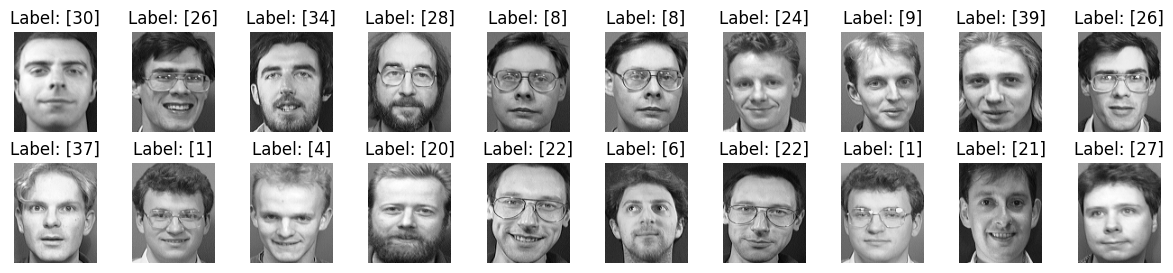

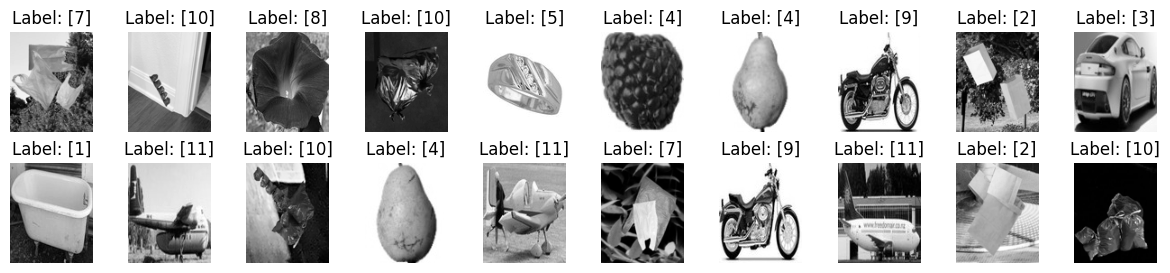

In [5]:
def plot_data(faces, labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(faces[i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(faces, labels,20)
plot_data(non_faces, non_labels,20)

## split the dataset into training and testing

In [7]:
# function to split the data into training and testing which alpha is the percentage of the training data
def split_data(faces, faces_labels, non_faces,non_faces_labels, non_faces_count, alpha, non_face_precentage_in_train=1):
    if alpha == 0.5:
        faces_train = faces[::2]  #even indices.
        faces_train_labels = faces_labels[::2]
        faces_test = faces[1::2]  #odd indices.
        faces_test_labels = faces_labels[1::2]

        non_faces_train = non_faces[:int(non_faces_count*non_face_precentage_in_train):2]
        non_faces_train_labels = non_faces_labels[:int(non_faces_count*non_face_precentage_in_train):2]

        non_faces_test = non_faces[1:non_faces_count:2]
        non_faces_test_labels = non_faces_labels[1:non_faces_count:2]
    else:
        n = len(faces)
        n_train = int(n*alpha)    #no. of training samples
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        faces_train = faces[train_idx]
        faces_train_labels = faces_labels[train_idx]
        faces_test = faces[test_idx]
        faces_test_labels = faces_labels[test_idx]
        
        n = non_faces_count
        n_train = int(n*alpha)
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        non_faces_train = non_faces[train_idx]
        non_faces_train_labels = non_faces_labels[train_idx]
        non_faces_test = non_faces[test_idx]
        non_faces_test_labels = non_faces_labels[test_idx]

    return np.append(faces_train, non_faces_train, axis=0), np.append(faces_train_labels, non_faces_train_labels, axis=0), np.append(faces_test, non_faces_test, axis=0), np.append(faces_test_labels, non_faces_test_labels, axis=0)


train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels,400 , 0.5, 1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(400, 10304) (400, 1) (400, 10304) (400, 1)


# display samples of training data and test data

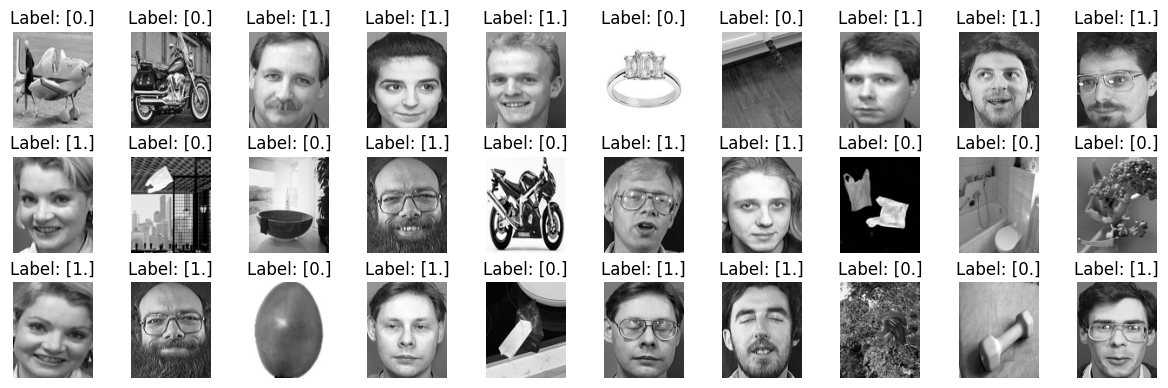

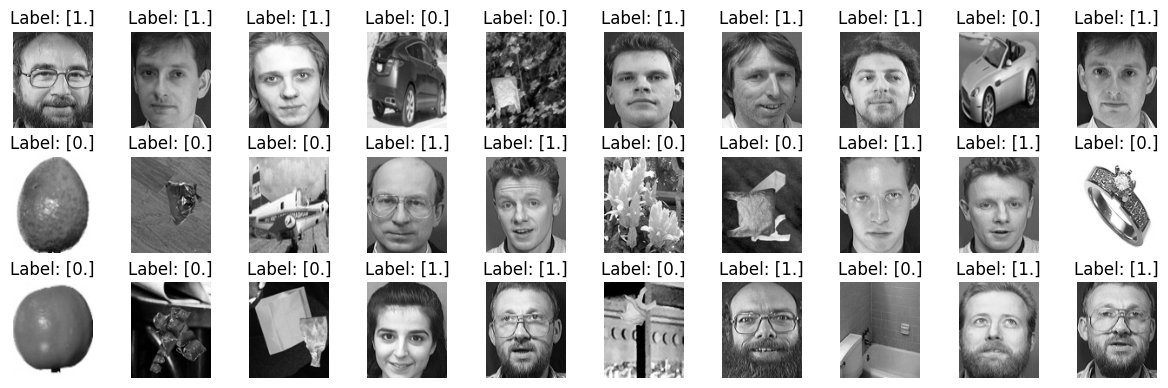

In [8]:
train_data, train_labels = shuffle_data( train_data,train_labels)
test_data, test_labels = shuffle_data( test_data,  test_labels)

plot_data(train_data, train_labels,30)
plot_data(test_data, test_labels,30)

## PCA imlementation

In [9]:
def PCA(train_data,alpha=0.95):
    # compute the mean of the training data
    mean = np.mean(train_data, axis=0)
    
    # subtract the mean from the training data
    centered_data = train_data - mean
    
    # compute the covariance matrix
    cov_matrix = np.dot(centered_data,centered_data.T)
    
    # compute the eigenvalues and eigenvectors
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    
    # restore the original eigenvectors
    eig_vectors = np.dot(centered_data.T,eig_vectors)
    
    # normalize the eigenvectors_converted
    for i in range(eig_vectors.shape[1]):
        eig_vectors[:,i] = eig_vectors[:,i]/np.linalg.norm(eig_vectors[:,i])

    k = 0
    var = 0
    while var/np.sum(eig_values) < alpha:
        var += eig_values[k]
        k += 1
        
    print(f"Using {k} components to retain {alpha*100}% of the variance")
    return eig_vectors[:,:k], mean

space,mean= PCA(train_data,0.85)


Using 40 components to retain 85.0% of the variance


# Plot the eign images

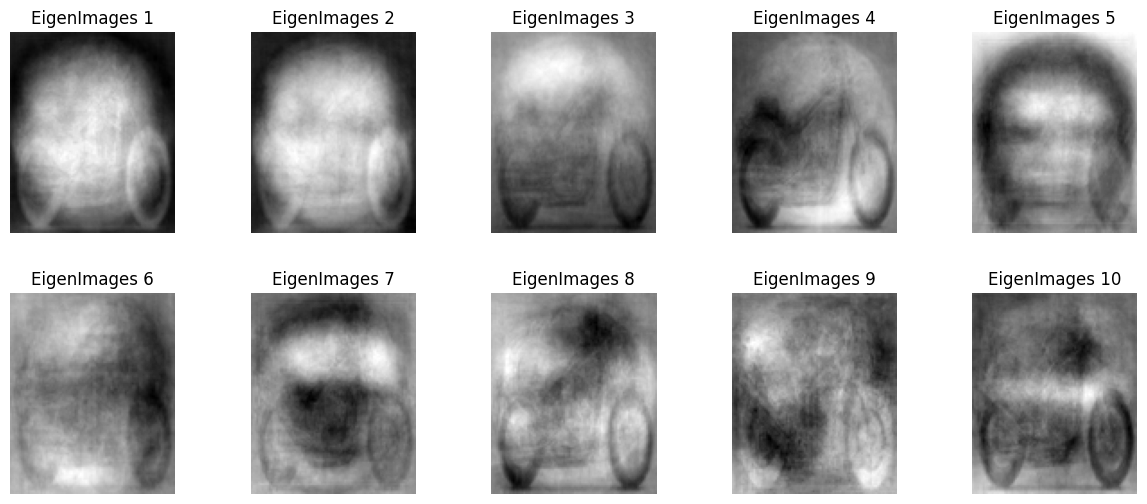

In [10]:
def plot_eigenfaces(eigenvectors, n=10):
    num_rows = n // 5
    fig , axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(eigenvectors[:, i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"EigenImages {i+1}")
        axs[i].axis("off")
    plt.show()
plot_eigenfaces(space, 10)

## Project the data

In [11]:
def project_data(data, eigenvectors, mean,):
    return np.dot(data - mean, eigenvectors)

#train_projected = project_data(train_data, space, mean)
train_projected = np.dot(train_data - mean, space)
#test_projected = project_data(test_data, space, mean)
test_projected = np.dot(test_data - mean, space)

## Classification and show the accuracy

In [12]:
def knn_classifier(train_data, train_labels, test_data, test_labels, k=1):
    knn = KNeighborsClassifier( n_neighbors=1, weights='distance')
    knn.fit( train_data, train_labels.ravel() )
    return accuracy_score(test_labels, knn.predict(test_data).ravel()), knn.predict(test_data).ravel()

print("Accuracy of KNN classifier with k=1:", knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[0])

Accuracy of KNN classifier with k=1: 0.925


# LDA

In [13]:
def LDA (train_data, train_labels, k=1):
    # mean of each class
    mean1 = np.mean(train_data[train_labels.ravel() == 1], axis=0)
    mean0 = np.mean(train_data[train_labels.ravel() == 0], axis=0)

    # within class scatter matrix (s1+s2)
    Sw = np.dot((train_data[train_labels.ravel() == 1] - mean1).T,
                (train_data[train_labels.ravel() == 1] - mean1)) + np.dot((train_data[train_labels.ravel() == 0] - mean0).T,
                                                                          (train_data[train_labels.ravel() == 0] - mean0))
    # between class scatter matrix
    Sb = np.dot((mean1 - mean0).reshape(-1,1), (mean1 - mean0).reshape(-1,1).T)

    # calculating the eigenvalues and eigenvectors
    eig_values, eig_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
    eig_values = np.real(eig_values)
    eig_vectors = np.real(eig_vectors)
    
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_vectors[:,:k]

## Project the data and check the accuracy

In [14]:
lda_space = LDA(train_data, train_labels)
train_lda_projected = np.dot(train_data, lda_space)
test_lda_projected = np.dot(test_data, lda_space)

print("Accuracy of KNN classifier with k=1 after LDA:", knn_classifier(train_lda_projected, train_labels, test_lda_projected, test_labels)[0])

Accuracy of KNN classifier with k=1 after LDA: 0.775


## Show failure and success cases.

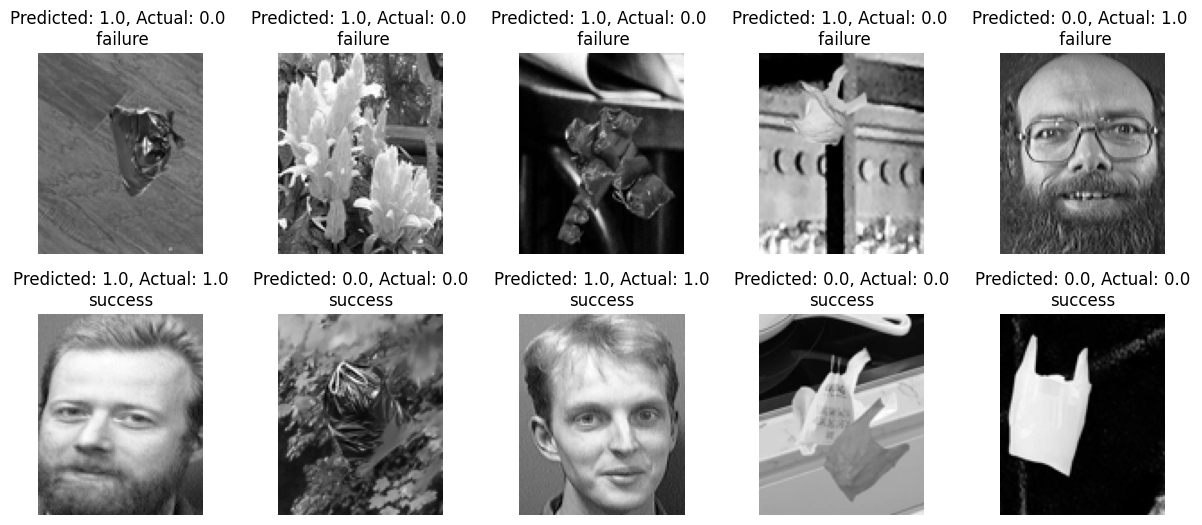

In [15]:
def plot_failure_and_success(data, labels, predictions, n=10):
    failure_idx = np.where(predictions != labels)[1]
    success_idx = np.where(predictions == labels)[1]
    num_rows = n // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()

    # annotate each row with failure or success
    for i in range(n):
        if i < n/2:               #Failure 
            axs[i].imshow(data[failure_idx[i]].reshape((112, 92)), cmap="gray")
            axs[i].set_title(f"Predicted: {predictions[failure_idx[i]]}, Actual: {labels[0,failure_idx[i]]} \n failure")
        else:                     #Success
            axs[i].imshow(data[success_idx[i-len(failure_idx)]].reshape((112, 92)), cmap="gray")
            axs[i].set_title(f"Predicted: {predictions[success_idx[i-len(failure_idx)]]}, Actual: {labels[0,success_idx[i-len(failure_idx)]]}\nsuccess")
        axs[i].axis("off")
    plt.show()

# plot_failure_and_success(test_data, test_labels.reshape(1,-1), knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[1], 10)
plot_failure_and_success(test_data, test_labels.reshape(1,-1), knn_classifier(train_lda_projected, train_labels, test_lda_projected, test_labels, 1)[1], 10)

## Plot the accuracy vs the number of non-faces images while fixing the number of face images.

Using 40 components to retain 85.0% of the variance
Using 38 components to retain 85.0% of the variance
Using 38 components to retain 85.0% of the variance
Using 39 components to retain 85.0% of the variance
Using 38 components to retain 85.0% of the variance
Using 39 components to retain 85.0% of the variance
Using 39 components to retain 85.0% of the variance
Using 40 components to retain 85.0% of the variance
Using 41 components to retain 85.0% of the variance
Using 40 components to retain 85.0% of the variance
Using 41 components to retain 85.0% of the variance


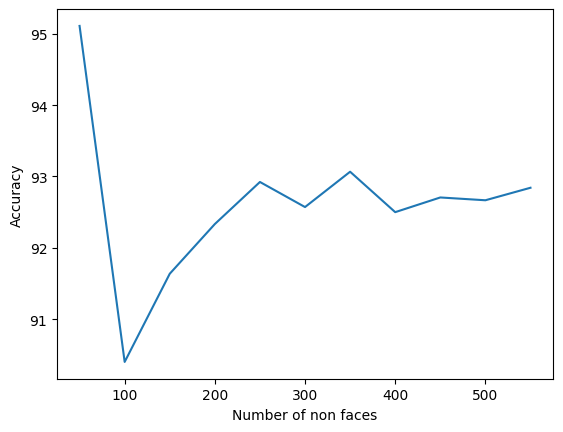

In [16]:
def plot_acc_vs_non_faces(algorithm,faces,faces_labels, non_faces,non_faces_labels,steps=50):
    acc = []
    n=len(non_faces)
    for i in range(steps,n+steps,steps):
        train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels,i,0.5,1)
        train_data, train_labels = shuffle_data( train_data,train_labels)
        test_data, test_labels = shuffle_data( test_data,  test_labels)
        if algorithm==0:
            space,mean= PCA(train_data,0.85)
            train_projected = project_data(train_data, space, mean)
            test_projected = project_data(test_data, space, mean)
            acc.append(knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[0]*100)
        else:
            lda_space = LDA(train_data, train_labels)
            train_lda_projected = np.dot(train_data, lda_space)
            test_lda_projected = np.dot(test_data, lda_space)
            acc.append(knn_classifier(train_lda_projected, train_labels, test_lda_projected, test_labels, 1)[0]*100)

    plt.plot(range(steps,n+steps,steps),acc)
    plt.xlabel("Number of non faces")
    plt.ylabel("Accuracy")
    plt.show()

plot_acc_vs_non_faces(0,faces,faces_labels, non_faces,non_faces_labels,steps=50)
# plot_acc_vs_non_faces(1,faces,faces_labels, non_faces,non_faces_labels,steps=150)


## Criticize the accuracy measure for large numbers of non-faces images in the training data.

Using 39 components to retain 85.0% of the variance
Using 39 components to retain 85.0% of the variance
Using 40 components to retain 85.0% of the variance
Using 41 components to retain 85.0% of the variance


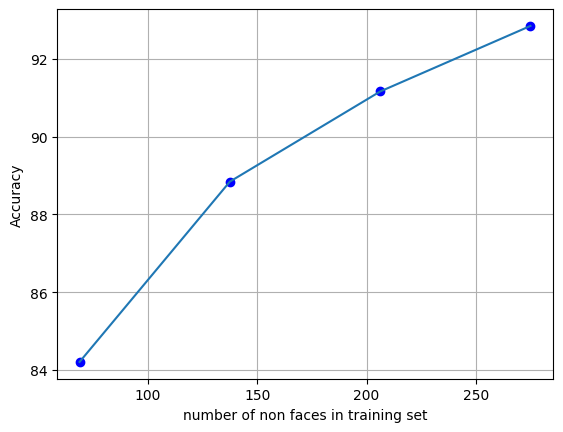

In [17]:
def acc_vs_non_faces_in_training(algorithm, faces, faces_labels, non_faces, non_faces_labels, step=4):
    acc = []
    n = len(non_faces)
    steps=np.linspace(step/step**2,1,step)  # steps for varying the proportion of non-face data.
    for i in steps:
        if algorithm==0:
            train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels, n, 0.5, i)
            train_data, train_labels = shuffle_data(train_data, train_labels)
            test_data, test_labels = shuffle_data(test_data, test_labels)
            space, mean = PCA(train_data, 0.85)
            train_projected = project_data(train_data, space, mean)
            test_projected = project_data(test_data, space, mean)
            acc.append(knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[0]*100)
        else:
            train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels, n, 0.5, i)
            train_data, train_labels = shuffle_data(train_data, train_labels)
            test_data, test_labels = shuffle_data(test_data, test_labels)
            lda_space = LDA(train_data, train_labels)
            train_lda_projected = np.dot(train_data, lda_space)
            test_lda_projected = np.dot(test_data, lda_space)
            acc.append(knn_classifier(train_lda_projected, train_labels, test_lda_projected, test_labels, 1)[0]*100)


    # plot the point of the accuracy curve
    plt.plot(steps*(n//2), acc)
    plt.scatter(steps*(n//2), acc,marker='o',color='b')
    plt.grid()
    plt.xlabel("number of non faces in training set")
    plt.ylabel("Accuracy")
    plt.show()

#test PCA   
acc_vs_non_faces_in_training(0,faces, faces_labels, non_faces, non_faces_labels)

#test LDA
# acc_vs_non_faces_in_training(1,faces, faces_labels, non_faces, non_faces_labels)


## Split the data into 70% training and 30% test, and compare the accuracy with 50% split

In [18]:
train_data70, train_labels70, test_data70, test_labels70 = split_data(faces, faces_labels, non_faces, non_faces_labels, 400, 0.7, 1)
train_data50, train_labels50, test_data50, test_labels50 = split_data(faces, faces_labels, non_faces, non_faces_labels, 400, 0.5, 1)

train_data70, train_labels70 = shuffle_data(train_data70, train_labels70)
test_data70, test_labels70 = shuffle_data(test_data70, test_labels70)

train_data50, train_labels50 = shuffle_data(train_data50, train_labels50)
test_data50, test_labels50 = shuffle_data(test_data50, test_labels50)

space70, mean70 = PCA(train_data70, 0.85)
space50, mean50 = PCA(train_data50, 0.85)

train_projected70 = project_data(train_data70, space70, mean70)
test_projected70 = project_data(test_data70, space70, mean70)

train_projected50 = project_data(train_data50, space50, mean50)
test_projected50 = project_data(test_data50, space50, mean50)


acc70 = knn_classifier(train_projected70, train_labels70, test_projected70, test_labels70, 1)[0]
acc50 = knn_classifier(train_projected50, train_labels50, test_projected50, test_labels50, 1)[0]

print("Accuracy of KNN classifier with k=1 after PCA with alpha=0.7:", acc70)
print("Accuracy of KNN classifier with k=1 after PCA with alpha=0.5:", acc50)


Using 47 components to retain 85.0% of the variance
Using 40 components to retain 85.0% of the variance
Accuracy of KNN classifier with k=1 after PCA with alpha=0.7: 0.95
Accuracy of KNN classifier with k=1 after PCA with alpha=0.5: 0.925
